In [1]:
# import new_adventure as na
# import new_adventure.derivative_free_estimation as dfe
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import yaml
import pickle

from utils import convert_opt_path

%load_ext autoreload
%autoreload 2

def load_opt_path(experiment_folder, process_id):
    with open(os.path.join(experiment_folder, process_id, "results.pkl"), "rb") as f:
        all_paths = pickle.load(f)
    return all_paths


In [15]:
d = 750
k = 5000
a = np.random.normal(size=(d, k))
b = np.random.normal(size=(k, d))
vec = np.random.normal(size=(d,))


In [11]:
vec.shape

(10000,)

In [16]:
start_time = time.time()
temp_vec = b.dot(vec)
a.dot(temp_vec)
print(time.time() - start_time)

0.011635303497314453


In [17]:
start_time = time.time()
c = a.dot(b)
c.dot(vec)
print(time.time() - start_time)

start_time = time.time()
a.dot(b.dot(vec))
print(time.time() - start_time)

start_time = time.time()
a.dot(b).dot(vec)
print(time.time() - start_time)


0.45508813858032227
0.004096269607543945
0.3973255157470703


In [18]:
# exp_path = "/Users/daniellengyel/new_adventure/experiments/linear/"
# exp_path = "/rds/general/user/dl2119/home/new_adventure/experiments/linear/"
exp_path = "/vol/bitbucket/dl2119/new_adventure/experiments/linear/"

bfgs_folder = "BFGS_Jun16_01-42-59_kingfisher.doc.ic.ac.uk"
bfgs_id = "1623804179.8215618"
bfgs_path = load_opt_path(exp_path + bfgs_folder, bfgs_id)

newton_folder = "Newton_IPM_Jun16_12-07-40_kingfisher.doc.ic.ac.uk"
newton_id = "1623841660.5062516"
newton_path = load_opt_path(exp_path + newton_folder, newton_id)

shift_folder = "Newton_multilevel_est_IPM_Jun16_13-40-51_kingfisher.doc.ic.ac.uk"
shift_id = "1623847251.5969687"
shift_path = load_opt_path(exp_path + shift_folder, shift_id)

shift_multi_folder = "Newton_multilevel_est_IPM_Jun16_12-13-25_kingfisher.doc.ic.ac.uk"
shift_multi_id = "1623842005.07865"
shift_multi_path = load_opt_path(exp_path + shift_multi_folder, shift_multi_id)

In [19]:


bfgs_vals = convert_opt_path(bfgs_path)
bfgs_vals[:, 1] -= bfgs_vals[1, 1]
newton_vals = convert_opt_path(newton_path)
newton_vals[:, 1] -= newton_vals[1, 1]
shift_vals = convert_opt_path(shift_path)
shift_vals[:, 1] -= shift_vals[1, 1]
shift_multi_vals = convert_opt_path(shift_multi_path)
shift_multi_vals[:, 1] -= shift_multi_vals[1, 1]

# bfgs_vals = np.array([[[np.sum(p[i][0]), p[i][1]] for i in range(len(p))] for p in bfgs_path ]).reshape(-1, 2)
# newton_vals = np.array([[[np.sum(p[i][0]), p[i][1]] for i in range(len(p))] for p in newton_path ]).reshape(-1, 2)
# shift_vals = np.array([[[np.sum(p[i][0]), p[i][1]] for i in range(len(p))] for p in shift_path ]).reshape(-1, 2)

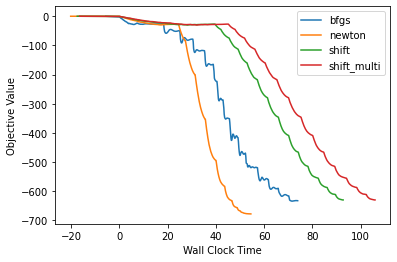

In [20]:
plt.plot(bfgs_vals[:, 1], bfgs_vals[:, 0], label="bfgs")
plt.plot(newton_vals[:, 1], newton_vals[:, 0], label="newton")
plt.plot(shift_vals[:, 1], shift_vals[:, 0], label="shift")
plt.plot(shift_multi_vals[:, 1], shift_multi_vals[:, 0], label="shift_multi")

plt.legend()
# plt.ylim(-6000, -5500)
plt.xlabel("Wall Clock Time")
plt.ylabel("Objective Value")
plt.show()

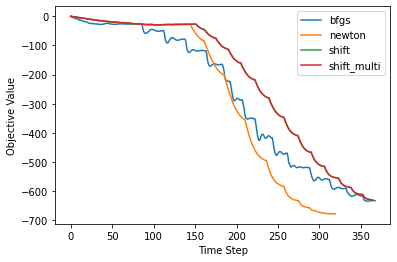

In [21]:
plt.plot(bfgs_vals[:, 0], label="bfgs")
plt.plot(newton_vals[:, 0], label="newton")
plt.plot(shift_vals[:, 0], label="shift")
plt.plot(shift_multi_vals[:, 0], label="shift_multi")

plt.legend()
# plt.ylim(-6000, -5500)
plt.xlabel("Time Step")
plt.ylabel("Objective Value")
plt.show()

In [37]:
def path_distance(path1, path2):
    res = []
    if len(path1) < len(path2):
        shorter = path1
        longer = path2
    else:
        shorter = path2
        longer = path1
        
    longer_j = 0
    for i in range(len(shorter)):
        longer_j = i
#         print(longer_j)
        while ((longer_j + 1) < len(longer)) and (np.linalg.norm(shorter[i] - longer[longer_j]) > np.linalg.norm(shorter[i] - longer[longer_j+1])):
            longer_j += 1
        res.append(np.linalg.norm(shorter[i] - longer[longer_j]))
        if longer_j == len(longer) - 2:
            break
        
        
    for i in range(min(len(path1), len(path2))):
        res.append(np.linalg.norm(path1[i] - path2[i]))
    return res

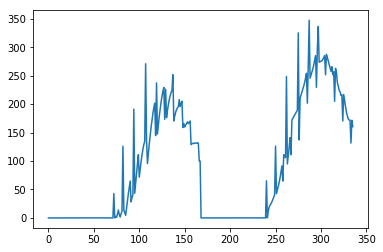

In [40]:
plt.plot(path_distance(shift_vals[:, 0], newton_vals[:, 0]))

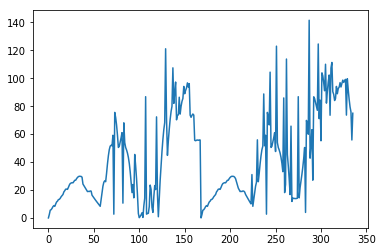

In [42]:
plt.plot(path_distance(bfgs_vals[:, 0], newton_vals[:, 0]))

In [29]:
t = 10
a = bfgs_path[t][-1][0]
# b = shift_path[t][-1][0]
# np.linalg.norm(a - b)

In [17]:
np.random.seed(10)
dim = 50
num_barriers = 2000
dirs = np.random.normal(size=(num_barriers, dim)) # sample gaussian and normalize 
ws = dirs/np.linalg.norm(dirs, axis=1).reshape(-1, 1)
bs = np.ones(num_barriers)


barrier = na.Barriers.LogPolytopeBarrier(ws, bs)

F = na.Functions.Linear(np.ones(dim))

F = barrier # na.Functions.LinearCombination(F, barrier, [1, 1])

In [59]:
est_hess = dfe.new_beta_second_shift_estimator(F, a[0], 200, 6000, control_variate=True)
true_hess = F.f2(np.array([a]))

est_inv_hess = np.linalg.inv(est_hess)
true_inv_hess = np.linalg.inv(true_hess)

In [60]:
np.linalg.norm(est_hess - true_hess)/np.linalg.norm(true_hess)

0.014561069440143938

In [61]:
np.linalg.norm(est_inv_hess - true_inv_hess)/np.linalg.norm(true_inv_hess)

0.022395838150512274

In [32]:
import time
x_0 = a[0]

times = []
alpha = 100
for i in range(1000, 5000, 100):
    a_time = time.time()
    dfe.multi_second_shift_estimator_task(x_0, F, i, alpha, [], [], 0, seed=0)
    times.append(time.time() - a_time)

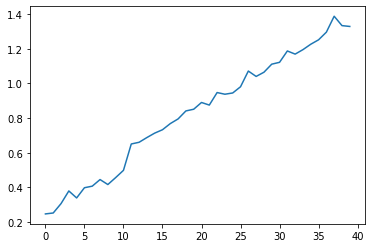

In [33]:
plt.plot(times)

In [24]:
import jax.numpy as jnp
import jax
from jax import random as jrandom

a = jnp.array([0.1, 0.9])

In [59]:
jrandom.choice(subkey, a=d_prime, shape=(d_prime, ))

DeviceArray([4, 6, 2, 0, 2, 0, 7, 6], dtype=int32)

In [57]:
d = 10
d_prime = 8
subkey = jrandom.PRNGKey(0)

idxs = jrandom.choice(subkey, a=d_prime, shape=(d_prime, ))
a = 2*jnp.array([range(d)])
a.T[idxs]

DeviceArray([[ 8],
             [12],
             [ 4],
             [ 0],
             [ 4],
             [ 0],
             [14],
             [12]], dtype=int32)

In [58]:
idxs

DeviceArray([4, 6, 2, 0, 2, 0, 7, 6], dtype=int32)

In [37]:
a

DeviceArray([[ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18]], dtype=int32)

In [55]:
jnp.eye(d)[idxs]

DeviceArray([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [49]:
grad_X = np.array([[ 7.04545226e-03,  3.48292319e-04, -1.53652971e-03,
               1.10500336e-03, -2.66119823e-03, -1.88702702e-03,
              -2.36083596e-03, -1.42945596e-03, -9.99106121e-05,
              -1.98972333e-03],
             [ 7.08445908e-04,  5.10577584e-03,  1.77929284e-03,
               7.67464441e-04,  3.96237061e-04, -1.10326504e-03,
              -1.67720919e-03,  9.55343146e-04, -7.98733099e-06,
              -2.76621836e-03],
             [-1.13618256e-03,  2.56599554e-03,  8.85736767e-03,
              -1.27534334e-03,  2.49738874e-03,  2.05140371e-03,
              -1.83339749e-03, -3.39062107e-03,  1.41591121e-03,
              -1.01286407e-04],
             [ 4.01188715e-04,  9.76009130e-05, -8.55132042e-04,
               6.87023751e-03,  1.48646373e-03, -1.11916145e-03,
               1.21086255e-03,  3.42207043e-03, -1.28300614e-03,
              -9.61896094e-04],
             [-1.77236282e-03,  1.27654580e-03,  3.19931453e-03,
               1.45701603e-03,  8.74118831e-03,  8.41719743e-04,
              -2.17453488e-03,  1.16284239e-03,  1.31491110e-03,
              -5.21211548e-04],
             [-1.79799443e-03, -7.46388401e-04,  1.20346804e-03,
              -1.48013608e-03,  1.07363947e-03,  8.16659940e-03,
              -1.21331015e-03, -7.24937143e-05,  7.38361370e-04,
              -1.66630613e-03],
             [-1.43087580e-03, -1.62704568e-03, -1.78418916e-03,
               7.56963566e-04, -2.01437898e-03, -1.18529688e-03,
               9.61463235e-03,  1.49631120e-03,  6.32607912e-05,
               2.70869948e-03],
             [-5.20623265e-04,  5.24458897e-04, -1.81103610e-03,
               2.23356272e-03,  6.48414037e-04, -3.49577054e-04,
               9.74923119e-04,  7.22266344e-03, -1.60198309e-03,
              -2.57490680e-03],
             [ 4.99546254e-04,  6.88618970e-04,  5.61070973e-04,
              -7.10661488e-04,  4.36810222e-04,  7.60263034e-04,
               3.16064323e-04, -1.16526300e-03,  4.90957007e-03,
              -5.70256292e-04],
             [-2.43205161e-03, -4.01689669e-03, -1.58713889e-03,
              -1.94877847e-03, -8.68057147e-05, -1.86732657e-03,
               2.17228781e-03, -3.36109109e-03, -5.13860371e-04,
               8.71866195e-03]])
U = np.array([[1., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 1., 0., 0, 0.],
             [0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 1.]])

In [44]:
np.linalg.inv(grad_X)

array([[ 234.47575014,   34.31218106,   45.02017031,  -51.08452198,
          68.66828074,   68.02874016,   74.83381504,   97.3640844 ,
         -10.82519411,   81.18839663],
       [  31.03276133,  337.1123535 ,  -55.06924294,   -0.77808516,
          11.91676332,   96.32670469,   48.01471637,  -22.73835196,
           2.7581012 ,  110.98422865],
       [  21.38609886, -103.42838018,  180.49140183,    6.69910931,
         -45.19859992,  -46.09157226,   -5.42807591,  106.45086688,
           3.46500552,   -3.25836291],
       [ -33.13167221,    8.97572111,    5.86310853,  199.95716636,
         -53.03781824,   15.03769306,  -36.90460423,  -72.43279102,
          39.71263234,    9.78974363],
       [  42.79946694,    0.78107297,  -62.07835392,  -56.12821197,
         174.89629634,    6.54719263,   59.78723803,  -56.80423174,
         -65.62354213,  -24.83447467],
       [  67.83845373,   92.9863325 ,   -3.68514025,   30.03767579,
          -2.7128086 ,  179.18504832,   31.35934349,   16

In [50]:
a = U.T.dot(grad_X).dot(U)

In [52]:
np.linalg.svd(a)

(array([[-3.60142789e-01,  4.35893326e-01, -2.98444621e-01,
          1.65411991e-01, -7.50908690e-01],
        [-2.51607789e-01, -7.10428863e-01,  4.53838659e-01,
         -1.40898377e-02, -4.75201325e-01],
        [ 6.76961605e-01,  2.08269395e-01,  4.34534729e-01,
          4.86866685e-01, -2.69234553e-01],
        [ 5.91335559e-04,  4.30940907e-01,  5.27887565e-01,
         -7.22123364e-01, -1.19004839e-01],
        [ 5.90519540e-01, -2.76046432e-01, -4.87314649e-01,
         -4.62535435e-01, -3.51668087e-01]]),
 array([0.01339097, 0.01058   , 0.00761233, 0.00503836, 0.00468393]),
 array([[-0.34770311, -0.28532533,  0.6798438 , -0.05312286,  0.57678624],
        [ 0.41819316, -0.68660431,  0.20775217,  0.47674645, -0.28851491],
        [-0.24212428,  0.52876277,  0.47699151,  0.52503337, -0.39825221],
        [ 0.26198349,  0.02064108,  0.48373143, -0.69278269, -0.46582685],
        [-0.75957719, -0.40883719, -0.1820287 , -0.11951104, -0.45659315]]))

In [53]:
np.linalg.inv(a)

array([[166.44683487,  40.34620788,  45.8102651 , -18.02226502,
         22.23367376],
       [ 24.87620306, 124.40995487,  27.73798446,  16.1176364 ,
          0.28300516],
       [ 16.63793085,  18.82838963, 122.89333605, -23.1362525 ,
        -36.71708447],
       [ -3.09848327,  14.34955443, -23.4055895 , 158.15504816,
         24.17982516],
       [ 46.12045432,  32.41820369, -18.02283915,  39.02176766,
        135.50288049]])

In [60]:
jrandom.choice(subkey, a=d_prime, shape=(d_prime, ))


DeviceArray([4, 6, 2, 0, 2, 0, 7, 6], dtype=int32)